In [91]:
import requests
import json
import time
import numpy as np
from bs4 import BeautifulSoup

In [5]:
import numpy as np
import pandas as pd
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.externals import joblib

import matplotlib.pyplot as plt

from collections import OrderedDict
from numpy import array

%matplotlib inline

In [8]:
token='<твой токен>'

In [9]:
data = requests.get(f'https://api.vk.com/method/friends.getLists&v=5.21&access_token={token}')

In [10]:
data = requests.get(f'https://api.vk.com/method/users.get?user_ids=peter_pogorelov&v=5.21&access_token={token}')
txt = data.content.decode('utf-8')
txt

'{"response":[{"id":31565880,"first_name":"Петр","last_name":"Погорелов"}]}'

In [103]:
def call_method(ref: str):
    data = requests.get(ref)
    txt = data.content.decode('utf-8')
    try:
        return json.loads(txt)['response']
    except:
        print(data)
        return {}

In [12]:
data = requests.get(f'https://api.vk.com/method/friends.get?user_id=31565880&v=5.21&access_token={token}')
txt = data.content.decode('utf-8')
txt

'{"response":{"count":87,"items":[197566,2426101,2584353,2662014,2916089,3019280,3852245,4115132,4349181,5524610,6071064,6649825,8126979,8482594,9470230,9724511,9812662,10051843,12664754,12756255,13211076,13567494,13902892,14600974,15020784,16737867,18098757,18408799,20502041,21519817,21693413,22113889,25635154,25933592,26614642,27072226,27843790,30770645,32881064,36334618,37720658,39435608,41455425,44649593,46430427,46942999,51330684,51350180,51401509,52508101,56558873,56654264,58763072,59765473,61226335,61522375,62148144,64850082,71139710,72381200,77495835,77713485,87962080,94273466,105605445,116108892,116756984,119553682,125075994,145586920,178120588,180173990,184805648,186927688,189776188,190542185,215471866,215946671,216896322,228615718,230558590,248567453,271938182,361674487,367378139,389103046,452397763]}}'

In [31]:
call_method(f'https://api.vk.com/method/users.get?user_id=31565880&fields=universities,occupation,sex&v=5.21&access_token={token}')

[{'id': 31565880,
  'first_name': 'Петр',
  'last_name': 'Погорелов',
  'sex': 2,
  'universities': []}]

In [135]:
call_method(f'https://api.vk.com/method/users.get?user_id=31565880&fields=universities,occupation,sex&v=5.21&access_token={token}')

[{'id': 31565880,
  'first_name': 'Петр',
  'last_name': 'Погорелов',
  'sex': 2,
  'universities': []}]

### БД Пользователей

In [136]:
db = {
    31565880: {
    }
}

db[31565880]['data']= call_method(f'https://api.vk.com/method/users.get?user_id=31565880&fields=universities,occupation,sex,city&v=5.21&access_token={token}')
db[31565880]['friends']= call_method(f'https://api.vk.com/method/friends.get?user_id=31565880&v=5.21&access_token={token}')['items']

for i in db[31565880]['friends']:
    db[i] = {'data': call_method(f'https://api.vk.com/method/users.get?user_id={i}&fields=universities,occupation,sex,city&v=5.21&access_token={token}')}
    time.sleep(1)
    friends = call_method(f'https://api.vk.com/method/friends.get?user_id={i}&v=5.21&access_token={token}')
    time.sleep(1)
    if friends:
        db[i]['friends'] = friends['items']

{"error":{"error_code":18,"error_msg":"User was deleted or banned","request_params":[{"key":"user_id","value":"25635154"},{"key":"v","value":"5.21"},{"key":"method","value":"friends.get"},{"key":"oauth","value":"1"}]}}
{"error":{"error_code":18,"error_msg":"User was deleted or banned","request_params":[{"key":"user_id","value":"116108892"},{"key":"v","value":"5.21"},{"key":"method","value":"friends.get"},{"key":"oauth","value":"1"}]}}
{"error":{"error_code":18,"error_msg":"User was deleted or banned","request_params":[{"key":"user_id","value":"215946671"},{"key":"v","value":"5.21"},{"key":"method","value":"friends.get"},{"key":"oauth","value":"1"}]}}


In [107]:
import joblib

In [137]:
joblib.dump(db, './db.bin')

['./db.bin']

In [109]:
db = joblib.load('./db.bin')

In [178]:
my_friends = db[31565880]['friends']
adj_matrix = np.zeros((len(my_friends), len(my_friends)))
adj_matrix_uni = np.zeros_like(adj_matrix)
adj_matrix_job = np.zeros_like(adj_matrix)
adj_matrix_city = np.zeros_like(adj_matrix)

adj_matrix_uni_pot = np.zeros_like(adj_matrix)
adj_matrix_city_pot = np.zeros_like(adj_matrix)

females = list()
males = list()


# fill friends links

for i in range(len(my_friends)):
    if 'data' in db[my_friends[i]].keys() and type(db[my_friends[i]]['data']) == list and 'sex' in db[my_friends[i]]['data'][0]:
        if db[my_friends[i]]['data'][0]['sex'] == 2:
            males.append(i)
        elif db[my_friends[i]]['data'][0]['sex'] == 1:
            females.append(i)
    
    for j in range(i + 1, len(my_friends)):
        if i != j:
            if ('friends' in db[my_friends[j]].keys() and my_friends[i] in db[my_friends[j]]['friends']) or \
            ('friends' in db[my_friends[i]].keys() and my_friends[j] in db[my_friends[i]]['friends']):
                adj_matrix[i, j] = adj_matrix[j, i] = 1
                
                if 'data' in db[my_friends[j]].keys() and 'data' in db[my_friends[i]].keys():
                    if type(db[my_friends[j]]['data']) != list or type(db[my_friends[i]]['data']) != list:
                        continue
                        
                    if 'occupation' in db[my_friends[i]]['data'][0] and 'occupation' in db[my_friends[j]]['data'][0]:
                        i_occupation = db[my_friends[i]]['data'][0]['occupation']
                        j_occupation = db[my_friends[j]]['data'][0]['occupation']
                        
                        if i_occupation['type'] == 'work' and j_occupation['type'] == 'work':
                            if i_occupation['name'] == j_occupation['name']:
                                adj_matrix_job[i, j] = adj_matrix_job[j, i] = 1
                        
                        
                    if 'universities' in db[my_friends[i]]['data'][0] and 'universities' in db[my_friends[j]]['data'][0]:
                        i_universities = set([u['name'] for u in db[my_friends[i]]['data'][0]['universities']])
                        j_universities = set([u['name'] for u in db[my_friends[j]]['data'][0]['universities']])
                        if len(i_universities.intersection(j_universities)) > 0:
                            adj_matrix_uni[i, j] = adj_matrix_uni[j, i] = 1
                            
                    if 'city' in db[my_friends[i]]['data'][0] and 'city' in db[my_friends[j]]['data'][0]:
                        city_i = db[my_friends[i]]['data'][0]['city']
                        city_j = db[my_friends[j]]['data'][0]['city']
                        
                        if city_i['title'] == city_j['title']:
                            adj_matrix_city[i, j] = adj_matrix_city[j, i] = 1
            else:
                if 'data' in db[my_friends[j]].keys() and 'data' in db[my_friends[i]].keys():
                    if type(db[my_friends[j]]['data']) != list or type(db[my_friends[i]]['data']) != list:
                        continue
                        
                    if 'universities' in db[my_friends[i]]['data'][0] and 'universities' in db[my_friends[j]]['data'][0]:
                        i_universities = set([u['name'] for u in db[my_friends[i]]['data'][0]['universities']])
                        j_universities = set([u['name'] for u in db[my_friends[j]]['data'][0]['universities']])
                        if len(i_universities.intersection(j_universities)) > 0:
                            adj_matrix_uni_pot[i, j] = adj_matrix_uni_pot[j, i] = 1
                            
                    if 'city' in db[my_friends[i]]['data'][0] and 'city' in db[my_friends[j]]['data'][0]:
                        city_i = db[my_friends[i]]['data'][0]['city']
                        city_j = db[my_friends[j]]['data'][0]['city']
                        
                        if city_i['title'] == city_j['title']:
                            adj_matrix_city_pot[i, j] = adj_matrix_city_pot[j, i] = 1

In [181]:
print('общая работа:', adj_matrix_job.sum() / 2)
print('общий вуз:', adj_matrix_uni.sum() / 2)
print('общий город:', adj_matrix_city.sum() / 2)
print('общий вуз:', adj_matrix_uni_pot.sum() / 2)
print('общий город:', adj_matrix_city_pot.sum() / 2)

общая работа: 0.0
общий вуз: 158.0
общий город: 172.0
общий вуз: 266.0
общий город: 823.0


In [141]:
graph = nx.from_numpy_matrix(adj_matrix)

In [114]:
# Ребята, у кого есть sex

In [115]:
colors = list()

for node in graph:
    if node in females:
        colors.append('red')
    elif node in males:
        colors.append('blue')
    else:
        colors.append('gray')

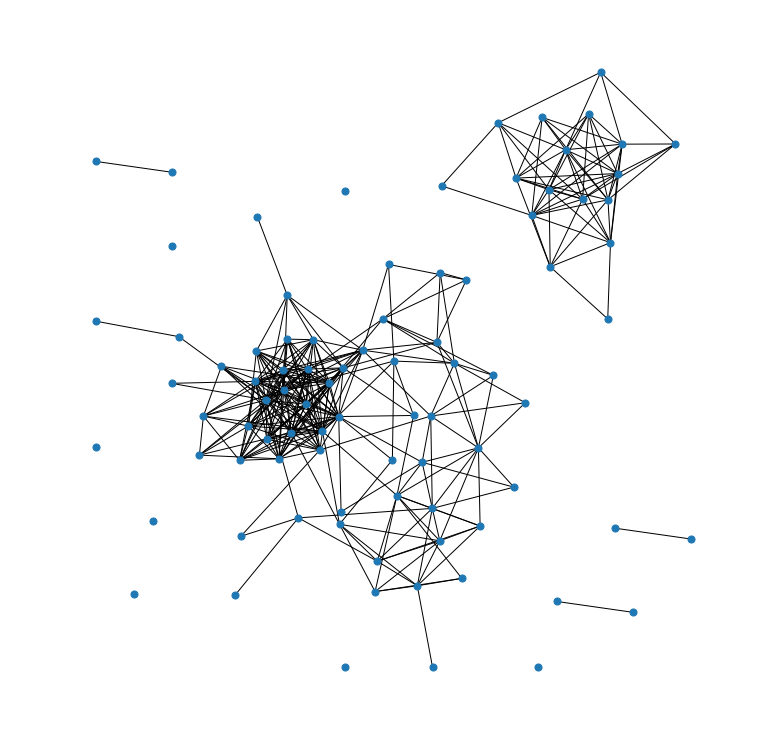

In [125]:
plt.figure(figsize=(10, 10))
pos=graphviz_layout(graph)
#nx.draw_networkx_labels(graph, pos, {k: v for k, v in enumerate(my_friends)},font_size=8)
nx.draw(graph, pos, node_color = None, node_size=50)

In [119]:
# Общая работа

In [167]:
graph = nx.from_numpy_matrix(adj_matrix)

In [168]:
edge_colors = list()
edge_width = list()
for a, b in graph.edges():
    c = 'gray'
    w = 1
    if adj_matrix_city[a, b] == 1:
        c = 'blue'
        w = 3
    edge_colors.append(c)
    edge_width.append(w)

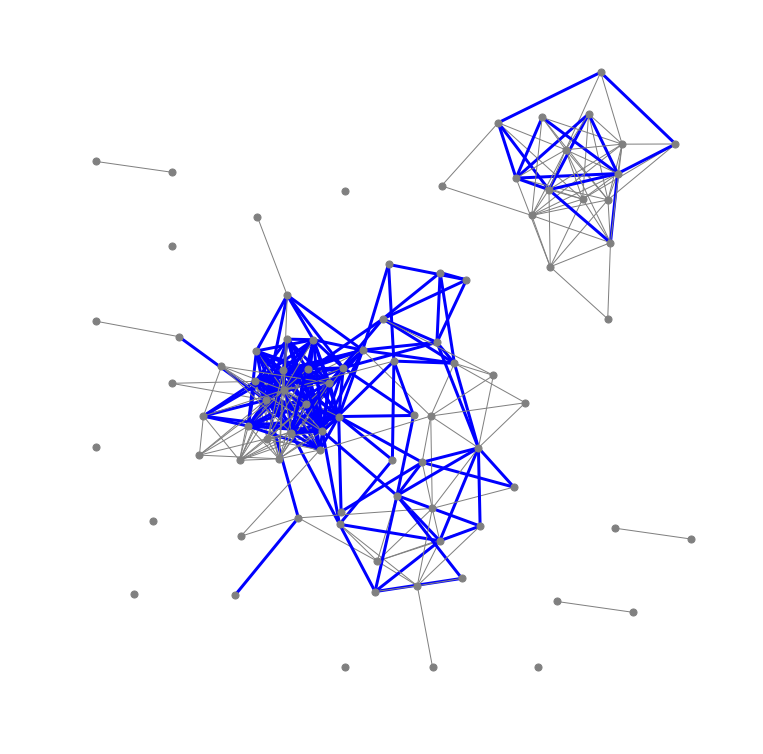

In [177]:
plt.figure(figsize=(10, 10))
pos=graphviz_layout(graph)
#nx.draw_networkx_labels(graph, pos, {k: v for k, v in enumerate(my_friends)},font_size=8)
nx.draw(graph, pos, node_color='gray', edge_color = edge_colors, width=edge_width, node_size=50)

In [196]:
graph = nx.from_numpy_matrix(adj_matrix.astype(bool) | adj_matrix_city_pot.astype(bool))

In [197]:
edge_colors = list()
edge_width = list()
for a, b in graph.edges():
    c = 'gray'
    w = 1
    if adj_matrix_city_pot[a, b] == 1:
        c = 'blue'
        w = 3
    edge_colors.append(c)
    edge_width.append(w)

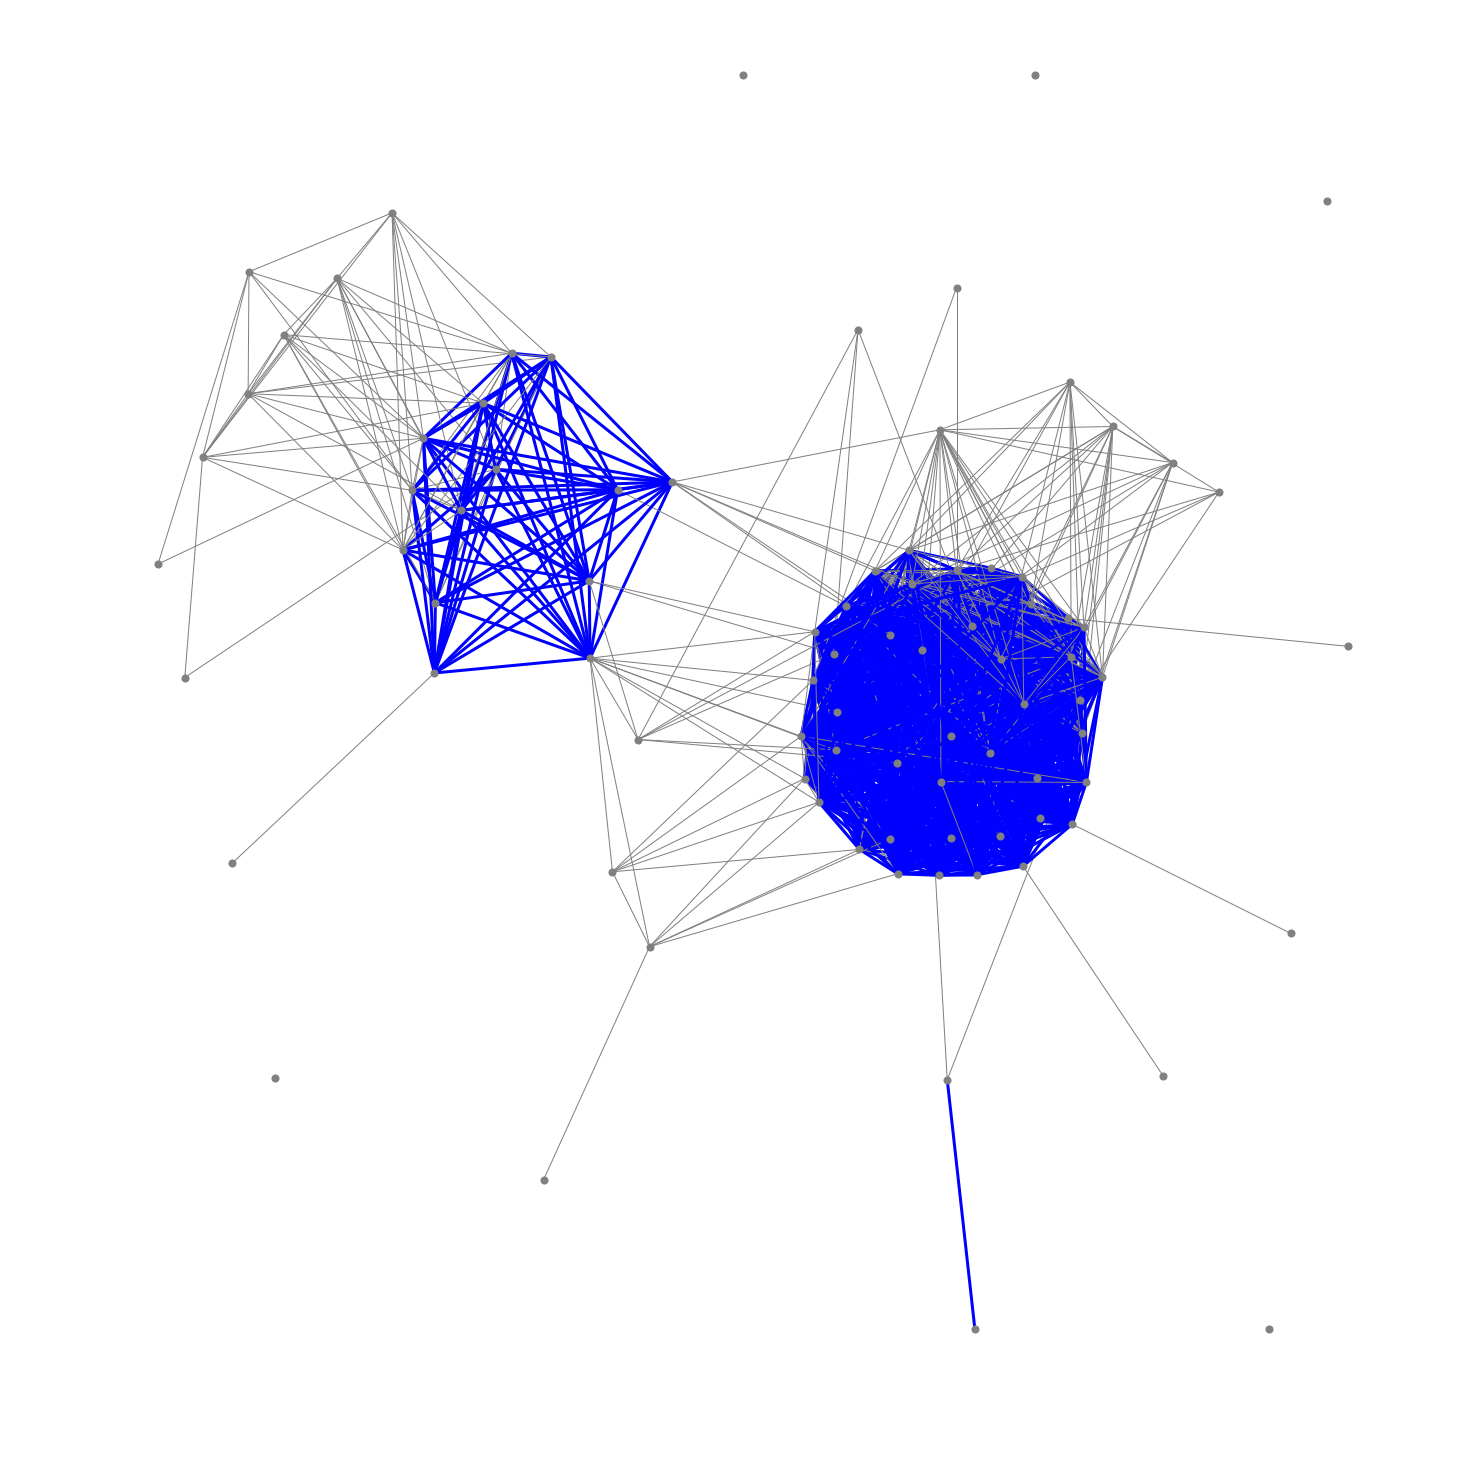

In [199]:
plt.figure(figsize=(20, 20))
pos=graphviz_layout(graph)
#nx.draw_networkx_labels(graph, pos, {k: v for k, v in enumerate(my_friends)},font_size=8)
nx.draw(graph, pos, node_color='gray', edge_color = edge_colors, width=edge_width, node_size=50)